In [1]:
import numpy as onp
from scipy.sparse import csc_matrix
import jax
import jax.numpy as np
from jax.experimental.sparse import BCOO
import time
from itertools import combinations
import math
from functools import partial
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from CFEM_utilities import *
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this for memory pre-allocation
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from jax.config import config
config.update("jax_enable_x64", True)

onp.set_printoptions(threshold=sys.maxsize, linewidth=1000, suppress=True, precision=4)

# Convolution HiDeNN (or C-FEM)


Get patch information

Compute radial basis functions

Compute assembled moment matrix G and vectorize

Compute C-HiDeNN shape function and shape function gradients

CFEM global stiffness and force vector builder


- - - - - - CFEM D1LN2N DOFs: 5, nelem_x: 4 with s: 2, a: 1000, p: -1 - - - - - -
CFEM adj_s matrix took 0.0007 seconds
edex_max / ndex_max: 5 / 5, took 0.0003 seconds
step = 0, res l_2 = 0.6654540093827862
CG solver took 0.0033 seconds


<Figure size 640x480 with 0 Axes>

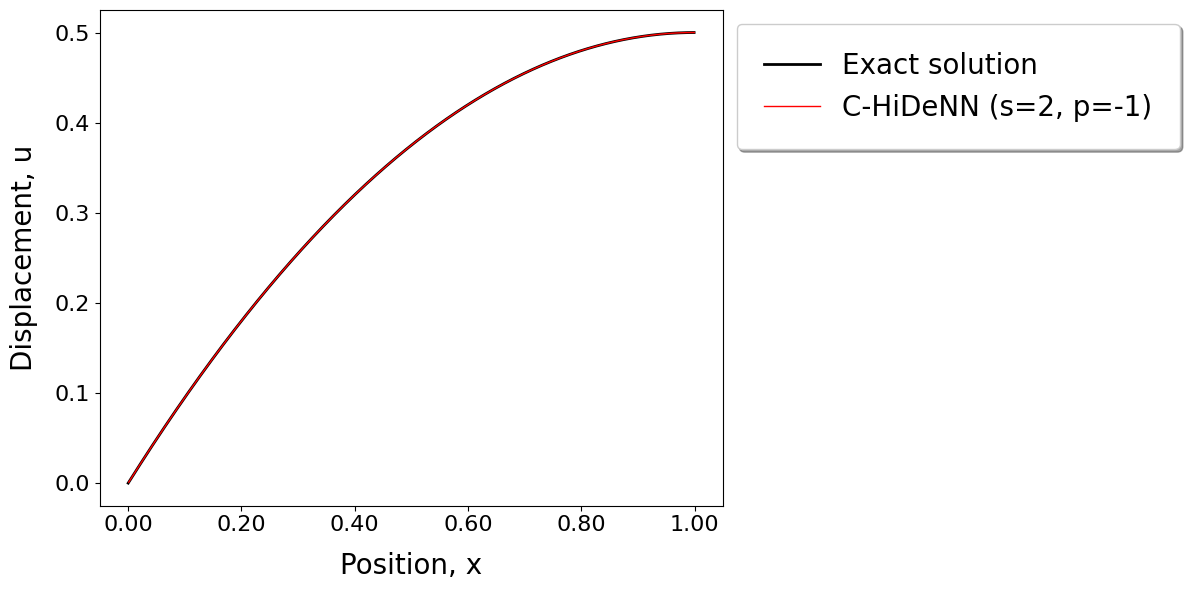

<Figure size 640x480 with 0 Axes>

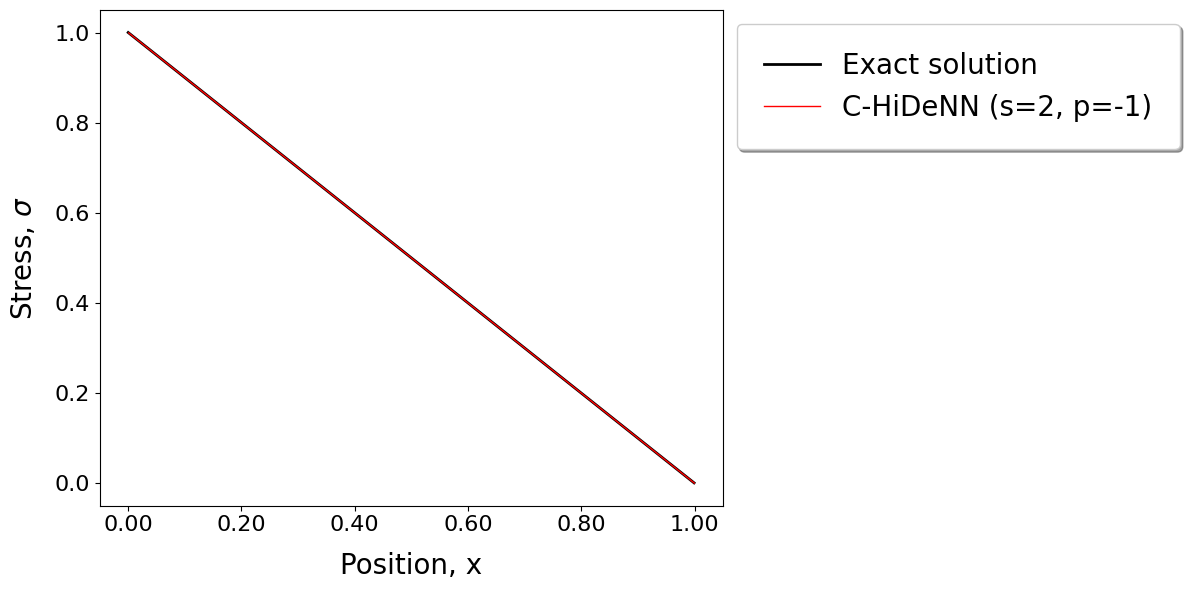

In [3]:
# Problem settings
s_patch = 2       # patch_size
p = -1              # reproducing polynomial order. [0, 1, 2, 3]. -1 means that p is equal to s.
alpha_dil = 1000       # dilation parameter
nelem_x = 4            # [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
elem_type = 'D1LN2N' # 'D1LN2N'


    # for s_patch in s_patches:
    #     for p in ps: # polynomial orders
    #         if p == -1:
    #             p = s_patch
    #         mbasis = p_dict[p]  
    #         for alpha_dil in alpha_dils:
    #             for nelem_x in nelems:


run_FEM = False
run_HiDeNN = False
run_CFEM = True

plot_bool = True
non_uniform_mesh_bool = True


# uniform body force
@jax.jit
def u_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    u = 1/2*(2*L*x-x**2)
    return u

@jax.jit
def Grad_u_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    dudx = (L-x)
    return dudx

@jax.jit
def b_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    b = 1
    return b

F = 0 # traction force at the right end

## Properties
L = 1 # length of the domain
E = 1 # Young's modulus
A = 1 # Cross-section area

#%%

nodes_per_elem = int(elem_type[4:-1])
dim = int(elem_type[1])
elem_dof = nodes_per_elem*dim    

p_dict={0:0, 1:2, 2:3, 3:4} 
u_fun = u_fun_1D
vv_b_fun = jax.vmap(jax.vmap(b_fun_1D, in_axes = (0, None)), in_axes = (0, None))
vv_u_fun = jax.vmap(jax.vmap(u_fun_1D, in_axes = (0, None)), in_axes = (0, None))
vv_Grad_u_fun = jax.vmap(jax.vmap(Grad_u_fun_1D, in_axes = (0, None)), in_axes = (0, None))
Gauss_Num_FEM = 8 # 6
Gauss_Num_CFEM = 8  # 6
Gauss_Num_norm = 20  # 8 or higher is enough



mbasis = p_dict[2]  

        
# Problem setting



## Mesh generation
XY_host, Elem_nodes_host, nelem, nnode, dof_global = uniform_mesh(L, nelem_x, dim, nodes_per_elem, 
                                                                    elem_type, non_uniform_mesh_bool)
Es = np.ones(nelem, dtype=np.double) * E
As = np.ones(nelem, dtype=np.double) * A

## Displacement boundary condition
disp_BC_idx = np.array([0])     # nodal index where the Dirichlet boundary condition is imposed
disp_BC = np.array([0], dtype=np.double) # Dirichlet boundary condition value

## host to device array
XY = np.array(XY_host)
Elem_nodes = np.array(Elem_nodes_host)

##### Exact solution
x_space_exact = np.arange(0,L,0.001)
u_exact = onp.zeros_like(x_space_exact)
strain_exact = onp.zeros_like(x_space_exact)
stress_exact = onp.zeros_like(x_space_exact)
for idx, x in enumerate(x_space_exact):
    u_exact[idx] = u_fun_1D(x, L)
    strain_exact[idx] = Grad_u_fun_1D(x, L)
    stress_exact[idx] = E * strain_exact[idx]
    
#####FEM
# print(f"\n----------------- FEM elem_tpye: {elem_type}, nelem_x: {nelem_x}, DOFs: {dof_global} --------------------")

# # Run FEM
# A_sp_scipy, b = get_A_b_FEM(XY, Elem_nodes, Es, As, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global)
# sol = Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC)

# # Compute errors
# L2_norm_FEM, H1_norm_FEM = get_FEM_norm(XY, Elem_nodes, sol, Gauss_Num_norm, dim, elem_type)

# # Compute Disp, strain, stress field for plotting
# shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # [quad_num_ctr, nodes_per_elem]
# shape_grads_physical, JxW = get_shape_grads(Gauss_Num_norm, dim, elem_type, XY, Elem_nodes)   
# physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
# x_space_FEM = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2).reshape(-1)

# u_coos = np.take(sol, Elem_nodes, axis=0) # (nelem, nodes_per_elem)
# disp_FEM = np.sum(shape_vals[None, :, :] * u_coos[:, None, :], axis=2).reshape(-1)
# strain_FEM = np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2).reshape(-1)
# stress_FEM = (Es[:,None,None] * np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2)).reshape(-1) # (nelem, quad_num, dim) -> (1,)

    

    
    
#%% ########################## CFEM ######################


# compute adjacency matrix - Serial
print(f"\n- - - - - - CFEM {elem_type} DOFs: {dof_global}, nelem_x: {nelem_x} with s: {s_patch}, a: {alpha_dil}, p: {p} - - - - - -")  

start_time_org = time.time()
indices, indptr = get_adj_mat(Elem_nodes_host, nnode, s_patch)
print(f"CFEM adj_s matrix took {time.time() - start_time_org:.4f} seconds")


# patch settings
d_c = L/nelem_x         # characteristic length in physical coord.
a_dil = alpha_dil * d_c # normalize the dilation parameter in the physical coord.

# Compute Elemental patch - Serial code
start_time = time.time()
edex_max, ndex_max = get_dex_max(indices, indptr, s_patch, Elem_nodes_host, nelem, nodes_per_elem, dim)
print(f'edex_max / ndex_max: {edex_max} / {ndex_max}, took {time.time() - start_time:.4f} seconds')

# Run CFEM
A_sp_scipy, b = get_A_b_CFEM(XY, XY_host, Elem_nodes, Elem_nodes_host, Es, As, Gauss_Num_CFEM, dim, elem_type, nodes_per_elem,
                            indices, indptr, s_patch, edex_max, ndex_max,
                                a_dil, mbasis, vv_b_fun, L)
sol = Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC)


# Post-processing Compute Disp, eps, strain field for plotting
shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # [quad_num_ctr, nodes_per_elem]
physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
x_space_CFEM = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2).reshape(-1)

(N_til, Grad_N_til, JxW, 
    Elemental_patch_nodes_st, Elem_nodes) = get_CFEM_shape_fun(onp.arange(nelem), nelem,
            XY, XY_host, Elem_nodes, Elem_nodes_host, shape_vals, Gauss_Num_norm, dim, elem_type, nodes_per_elem,
            indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis)
                                                
u_coos = np.take(sol, Elemental_patch_nodes_st, axis=0) # (nelem, nodes_per_elem)
disp_CFEM = np.sum(N_til[:, :, :] * u_coos[:, None, :], axis=2).reshape(-1)
strain_CFEM = np.sum(Grad_N_til[:, :, :, :] * u_coos[:, None, :, None], axis=2).reshape(-1) # (nelem, quad_num, dim) -> (1,)
stress_CFEM = (Es[:,None,None] * np.sum(Grad_N_til[:, :, :, :] * u_coos[:, None, :, None], axis=2)).reshape(-1) # (nelem, quad_num, dim) -> (1,)


# Plot displacement
plot_disp(x_space_exact, u_exact, x_space_CFEM, disp_CFEM, s_patch, p)
# plot stress
plot_stress(x_space_exact, stress_exact, x_space_CFEM, stress_CFEM, s_patch, p)